In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report, confusion_matrix

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from pytorch_grad_cam import GradCAM

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')

In [4]:
#ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed/test_GroundTruth2.csv')
#ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed/train_GroundTruth2.csv')

ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed/test_umap_new_skincancer.csv')
ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed/train_umap_new_skincancer.csv')

In [5]:
mask_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/masks')
mask_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/masks')

In [6]:
train_ids = [f.stem for f in data_dir_train.glob("*.png")]
test_ids = [f.stem for f in data_dir_test.glob("*.png")]

In [7]:
#train_ids

In [8]:
class Dataset_skincancer_custom(Dataset):
    def __init__(self, image_dir, ground_truth_file, ids, mask_dir, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            ground truth: num
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.ground_truth_file = ground_truth_file
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.png").convert("RGB"))
        image = self.to_tensor(image)
        mask = np.array(Image.open(self.mask_dir / f"{name}_segmentation.png").convert("L"))
        mask = self.to_tensor(mask)
        
        # Load ground truth
        ground_truth_df = pd.read_csv(self.ground_truth_file)
        ground_truth = ground_truth_df[ground_truth_df['image_id'] == name][list(ground_truth_df.columns[1:])].values
        ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
        ground_truth = ground_truth.squeeze()
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)
        
        #print(image)
        #print(ground_truth)

        return image, ground_truth, mask

In [9]:
batch_size = 16

In [10]:
# Create datasets with transformations
dataset_train = Dataset_skincancer_custom(data_dir_train, ground_truth_file_train, train_ids, mask_dir_train)
dataset_test = Dataset_skincancer_custom(data_dir_test, ground_truth_file_test, test_ids, mask_dir_test)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [11]:
for i, item in enumerate(test_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0706, 0.0784],
          [0.0314, 0.0196, 0.1529,  ..., 0.2392, 0.0627, 0.0784],
          [0.0275, 0.0314, 0.3412,  ..., 0.4392, 0.0863, 0.0706],
          ...,
          [0.3922, 0.3490, 0.3412,  ..., 0.4824, 0.4627, 0.4471],
          [0.3961, 0.3451, 0.3451,  ..., 0.5059, 0.4941, 0.4196],
          [0.2784, 0.3451, 0.3451,  ..., 0.4941, 0.4706, 0.2706]],

         [[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0745, 0.0824],
          [0.0314, 0.0196, 0.1412,  ..., 0.2314, 0.0627, 0.0784],
          [0.0314, 0.0314, 0.3137,  ..., 0.4235, 0.0863, 0.0706],
          ...,
          [0.3137, 0.2471, 0.2275,  ..., 0.4588, 0.4353, 0.4235],
          [0.3529, 0.2392, 0.2275,  ..., 0.4863, 0.4745, 0.4039],
          [0.2549, 0.2431, 0.2314,  ..., 0.4706, 0.4471, 0.2588]],

         [[0.0314, 0.0314, 0.0353,  ..., 0.1137, 0.0784, 0.0902],
          [0.0314, 0.0196, 0.1412,  ..., 0.2353, 0.0706, 0.0863],
          [0.0314, 0.0353, 0.3176,  ..., 

In [12]:
for i, item in enumerate(train_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.7608, 0.7686, 0.7647,  ..., 0.7804, 0.7804, 0.7765],
          [0.7765, 0.7686, 0.7647,  ..., 0.7882, 0.7843, 0.7765],
          [0.7725, 0.7765, 0.7765,  ..., 0.7843, 0.7804, 0.7804],
          ...,
          [0.7608, 0.7569, 0.7647,  ..., 0.7490, 0.7529, 0.7490],
          [0.7529, 0.7569, 0.7647,  ..., 0.7529, 0.7608, 0.7529],
          [0.7569, 0.7608, 0.7608,  ..., 0.7569, 0.7529, 0.7569]],

         [[0.7490, 0.7608, 0.7686,  ..., 0.7686, 0.7725, 0.7765],
          [0.7608, 0.7608, 0.7765,  ..., 0.7843, 0.7882, 0.7882],
          [0.7529, 0.7647, 0.7765,  ..., 0.7961, 0.7961, 0.7922],
          ...,
          [0.7686, 0.7647, 0.7647,  ..., 0.7451, 0.7569, 0.7569],
          [0.7608, 0.7529, 0.7569,  ..., 0.7490, 0.7529, 0.7686],
          [0.7608, 0.7529, 0.7569,  ..., 0.7686, 0.7647, 0.7647]],

         [[0.6745, 0.6784, 0.6941,  ..., 0.7176, 0.7176, 0.7255],
          [0.6863, 0.6824, 0.7020,  ..., 0.7333, 0.7333, 0.7333],
          [0.6706, 0.6980, 0.7098,  ..., 

In [13]:
for i, item in enumerate(train_loader):
    print(item[1].shape)
    print(item[1])
    if i == 0:
        break

torch.Size([16, 2])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])


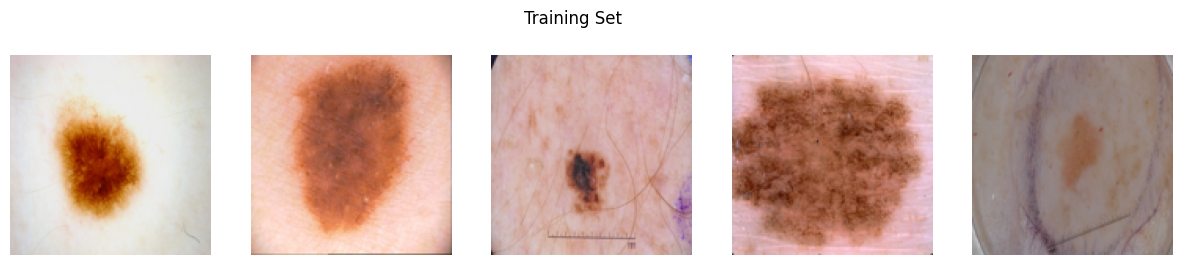

In [14]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, _, _) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
#plot_images(test_loader, "Test Set")

In [15]:
# create a custom convolutional neural network model for the classification task

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(192)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(384)
        self.relu3 = torch.nn.LeakyReLU()

        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.relu4 = torch.nn.LeakyReLU()

        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.relu5 = torch.nn.LeakyReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(256 * 3 * 3, 1024)
        self.relu6 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.2)

        self.fc2 = torch.nn.Linear(1024, 512)
        self.relu7 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.1)

        self.fc3 = torch.nn.Linear(512, 2)
        #self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.pool3(self.relu5(self.bn5(self.conv5(x))))
        
        x = self.flatten(x)

        x = self.relu6(self.fc1(x))
        #x = self.dropout1(x)

        x = self.relu7(self.fc2(x))
        #x = self.dropout2(x)

        x = self.fc3(x)
        return x
    
# create model
model = CustomCNN().to(device)
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyRe

In [16]:
# test model with a random input
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[ 0.1899, -0.1026]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [17]:
# test model with the first batch of the training data
for i, (image, ground_truth, _) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    ground_truth = ground_truth.to(device)
    output = model(image)
    # convert output to tensor with 1 on the predicted class and 0 on the other classes
    _, predicted_max = torch.max(output, 1)
    print(output)
    output = torch.zeros_like(output)
    output[torch.arange(output.size(0)), predicted_max] = 1
    print(output)
    print(ground_truth)
    print(ground_truth.shape)

tensor([[ 0.1052, -0.0942],
        [ 0.1011, -0.0652],
        [ 0.1309, -0.0364],
        [ 0.1410, -0.0994],
        [ 0.3600, -0.0681],
        [ 0.3660, -0.0219],
        [ 0.2036,  0.0074],
        [ 0.1328,  0.0071],
        [ 0.1279, -0.0159],
        [ 0.0877, -0.0715],
        [ 0.1638, -0.0975],
        [ 0.0465,  0.0009],
        [ 0.2052, -0.1614],
        [ 0.1509, -0.1120],
        [ 0.3235, -0.0817],
        [ 0.2729, -0.0315]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
    

In [18]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)  # Change final layer for 3-class classification
model = model.to(device)

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) #, weight=torch.tensor([(2000/374), (2000/254), (2000/1372)], device=device)

# train the model
accumulation_steps = 4
model.train()
for epoch in range(50):
    #if epoch == 1:
    #    break
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = len(train_loader)

    optimizer.zero_grad()

    for i, (images, ground_truth, _) in enumerate(train_loader):
        images, ground_truth = images.to(device), ground_truth.to(device)
        #ground_truth = ground_truth.float()
        
        outputs = model(images)
        #loss = criterion(outputs, ground_truth)
        #print(ground_truth)
        loss = criterion(outputs, ground_truth.argmax(dim=1))#(((outputs - ground_truth)* tensor_weights)**2).mean()
        #print("outputs")
        #print(outputs)

        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        predictions = torch.argmax(outputs, dim=1)
        #print("predictions")
        #print(predictions)
        #print("ground_truth")
        #print(ground_truth)

        #optimizer.step()
        
        accuracy = (predictions == ground_truth.argmax(dim=1)).float().mean()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss/num_batches}, Accuracy: {epoch_accuracy/num_batches}")

Epoch 1, Loss: 0.48400041162967683, Accuracy: 0.823
Epoch 2, Loss: 0.32158981657028196, Accuracy: 0.93
Epoch 3, Loss: 0.2743974829912186, Accuracy: 0.962
Epoch 4, Loss: 0.24715831637382507, Accuracy: 0.985
Epoch 5, Loss: 0.2513761510848999, Accuracy: 0.9795
Epoch 6, Loss: 0.24638139390945435, Accuracy: 0.9855
Epoch 7, Loss: 0.24179392659664153, Accuracy: 0.9875
Epoch 8, Loss: 0.2345692710876465, Accuracy: 0.9945
Epoch 9, Loss: 0.22847782254219054, Accuracy: 0.996
Epoch 10, Loss: 0.23054975688457488, Accuracy: 0.992
Epoch 11, Loss: 0.22392586064338685, Accuracy: 0.9975
Epoch 12, Loss: 0.2223864369392395, Accuracy: 0.998
Epoch 13, Loss: 0.22073507475852966, Accuracy: 0.997
Epoch 14, Loss: 0.22012494385242462, Accuracy: 0.998
Epoch 15, Loss: 0.22784907019138337, Accuracy: 0.996
Epoch 16, Loss: 0.2251794408559799, Accuracy: 0.9985
Epoch 17, Loss: 0.22016814851760863, Accuracy: 0.9985
Epoch 18, Loss: 0.22213880813121795, Accuracy: 0.995
Epoch 19, Loss: 0.21705843257904053, Accuracy: 0.998
E

In [20]:
# evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for images, ground_truth, _ in test_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        prediction_list = [0, 0]
        prediction_list[predicted.cpu().numpy()[0]] = 1
        predictions.append(prediction_list)

In [21]:
df_predicted = pd.DataFrame(predictions, columns=["0", "1"], index=test_ids)
df_predicted = df_predicted.sort_index()
df_predicted

,0,1
ISIC_0012086,1,0
ISIC_0012092,1,0
ISIC_0012095,0,1
ISIC_0012134,1,0
ISIC_0012136,0,1
...,...,...
ISIC_0016068,0,1
ISIC_0016069,1,0
ISIC_0016070,1,0
ISIC_0016071,1,0


In [22]:
df_predicted.sum()

0    241
1    359
dtype: int64

In [23]:
df_ground_truth = pd.read_csv(ground_truth_file_test, index_col='image_id')
df_ground_truth

,0,1
image_id,,
ISIC_0016028,1,0
ISIC_0014944,0,1
ISIC_0015990,1,0
ISIC_0016057,1,0
ISIC_0015089,0,1
...,...,...
ISIC_0015215,0,1
ISIC_0015142,0,1
ISIC_0016015,1,0


In [24]:
df_ground_truth.sum()

0    262
1    338
dtype: int64

In [25]:
# print mean absolute error
print("Mean Absolute Error:")
print((df_predicted - df_ground_truth).abs().mean())

Mean Absolute Error:
0    0.065
1    0.065
dtype: float64


In [26]:
labels_predicted = df_predicted[["0", "1"]].idxmax(axis=1)
labels_ground_truth = df_ground_truth[["0", "1"]].idxmax(axis=1)

In [27]:
labels_predicted

ISIC_0012086    0
ISIC_0012092    0
ISIC_0012095    1
ISIC_0012134    0
ISIC_0012136    1
               ..
ISIC_0016068    1
ISIC_0016069    0
ISIC_0016070    0
ISIC_0016071    0
ISIC_0016072    0
Length: 600, dtype: object

In [28]:
labels_ground_truth

image_id
ISIC_0016028    0
ISIC_0014944    1
ISIC_0015990    0
ISIC_0016057    0
ISIC_0015089    1
               ..
ISIC_0015215    1
ISIC_0015142    1
ISIC_0016015    0
ISIC_0012722    0
ISIC_0013814    0
Length: 600, dtype: object

In [29]:
# evaluate the model
print("Classification Report")
print(classification_report(labels_ground_truth, labels_predicted))

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.43      0.45       262
           1       0.58      0.62      0.60       338

    accuracy                           0.54       600
   macro avg       0.53      0.53      0.53       600
weighted avg       0.53      0.54      0.54       600



In [30]:
cm = confusion_matrix(labels_ground_truth, labels_predicted)
cm

array([[113, 149],
       [128, 210]])

In [31]:
import plotly.express as px
# plot confusion matrix
fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=["0", "1"],
                 y=["0", "1"], text_auto=True, width=600, height=600, color_continuous_scale='reds',
                   title="Confusion Matrix")
# remove colorbar
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [32]:
# save the model
#torch.save(model.state_dict(), "customCNN_new_skincancer_6classes_upgraded.pth")

---